# Toronto city clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Scrape Toronto zip codes from Wikipeda using beautifulsoup4

In [2]:
#!conda install beautifulsoup4
import requests
from bs4 import BeautifulSoup 
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url,"lxml") 
#find the table
soup = soup.find("table",{"class":"wikitable sortable"})
#find table rows
rows = soup.find_all("tr") 
# get column headers
column_headers = [th.getText() for th in 
                  rows[0].findAll('th')]

df = pd.DataFrame(columns=column_headers)
#read row data
for i, row in enumerate(rows[1:]): 
    zip_codes = [td.getText() for td in 
                  row.findAll('td')]
    df.loc[i]=zip_codes
#get rid of "\n" in headers and values   
df.replace("\n","",regex=True,inplace=True)
df.columns=[ col.replace('\n' , '')  for col in 
                  df.columns.astype("str") ]

#### Process zip codes
First, we drop zip codes with Not Assigned boroughs. 
Then rename Not Assigned neighborhoods to their borough's name.
Once it's done, we reset the index 

In [3]:
df = df[df["Borough"]!="Not assigned"]
df.Neighbourhood[df.Neighbourhood=="Not assigned"]=df.Borough
df = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()                  
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
df.shape

(103, 3)

Read geo coods from a csv file (geo API failed!) 

In [5]:
geo_df = pd.read_csv('Geospatial_Coordinates.csv')
geo_df.rename(columns={'Postal Code':'Postcode'}, inplace=True)
geo_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
#add Lat,Lon to the dataset
df = df.join(geo_df.set_index("Postcode"), on='Postcode')
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [11]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy #--yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


In [14]:
#FourSquare credentials
import yaml
FOURSQ_CONFIG_FILE = '4SQ.env'

with open(FOURSQ_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)
    
CLIENT_ID = config['FOURSQUARE']['CLIENT_ID']
CLIENT_SECRET = config['FOURSQUARE']['CLIENT_SECRET']
VERSION = '20180605' # Foursquare API version

radius = 500
limit = 1000

C:\Users\i861383\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [15]:
# create map of Toronto using latitude and longitude values
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude, longitude = location.latitude, location.longitude
food_category="4d4b7105d754a06374d81259"

map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            food_category)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Venue analysis
Let's analyze Asian restaurants located in Toronto Downtown borough

In [17]:
#names=["Parkwoods"]
names=df[df["Borough"]=="Downtown Toronto"]['Neighbourhood']
latitudes=df[df["Neighbourhood"].isin(names)]['Latitude']
longitudes=df[df["Neighbourhood"].isin(names)]['Longitude']

toronto_venues = getNearbyVenues(names, latitudes, longitudes)


Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie


In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(1068, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Saigonlotus,43.681281,-79.382401,Japanese Restaurant
1,"Cabbagetown, St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner
2,"Cabbagetown, St. James Town",43.667967,-79.367675,F'Amelia,43.667536,-79.368613,Italian Restaurant
3,"Cabbagetown, St. James Town",43.667967,-79.367675,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant
4,"Cabbagetown, St. James Town",43.667967,-79.367675,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant


In [19]:
#top 10 'hoods with most venues
toronto_venues.groupby('Neighborhood').count()["Venue"].to_frame().sort_values(by=['Venue'],ascending=False).head(10)

,Venue
Neighborhood,
"Design Exchange, Toronto Dominion Centre",100
"Commerce Court, Victoria Hotel",100
"First Canadian Place, Underground city",100
Stn A PO Boxes 25 The Esplanade,99
"Adelaide, King, Richmond",96
"Ryerson, Garden District",92
St. James Town,82
"Harbourfront East, Toronto Islands, Union Station",74
Central Bay Street,68


In [20]:
# 20 most popular venue categories
toronto_venues.groupby('Venue Category').count()["Venue"].to_frame().sort_values(by=['Venue'],ascending=False).head(20)

,Venue
Venue Category,
Café,95
Restaurant,80
Italian Restaurant,64
Sandwich Place,47
Pizza Place,43
Bakery,41
Sushi Restaurant,39
American Restaurant,37
Japanese Restaurant,35


In [21]:
print('There are {} uniques categories:'.format(len(toronto_venues['Venue Category'].unique())))
print(*list(toronto_venues['Venue Category'].unique()),sep = "\n")


There are 79 uniques categories:
Japanese Restaurant
Diner
Italian Restaurant
Indian Restaurant
Restaurant
Café
Bakery
Gastropub
Deli / Bodega
Taiwanese Restaurant
Caribbean Restaurant
Thai Restaurant
Sandwich Place
Pizza Place
Chinese Restaurant
American Restaurant
Bistro
Breakfast Spot
Sushi Restaurant
Theme Restaurant
Ramen Restaurant
Mexican Restaurant
Burger Joint
Creperie
Vietnamese Restaurant
Ethiopian Restaurant
Steakhouse
Wings Joint
Burrito Place
Afghan Restaurant
Mediterranean Restaurant
Middle Eastern Restaurant
Seafood Restaurant
Fast Food Restaurant
Persian Restaurant
Korean Restaurant
Soup Place
French Restaurant
Food Truck
Greek Restaurant
Asian Restaurant
Taco Place
Vegetarian / Vegan Restaurant
Coffee Shop
Modern European Restaurant
Falafel Restaurant
Poutine Place
Food Court
Fried Chicken Joint
BBQ Joint
Poke Place
New American Restaurant
Latin American Restaurant
Bagel Shop
Salad Place
German Restaurant
Eastern European Restaurant
Comfort Food Restaurant
Irish Pub
B

Let's focus on restaurants since they have natural clustering 

In [22]:
venues = toronto_venues.groupby('Venue Category').count()["Venue"].to_frame().sort_values(by=['Venue'],ascending=False)
#venues=venues[venues.index.str.contains("estaurant")]
venues

,Venue
Venue Category,
Café,95
Restaurant,80
Italian Restaurant,64
Sandwich Place,47
Pizza Place,43
Bakery,41
Sushi Restaurant,39
American Restaurant,37
Japanese Restaurant,35


There are too many restaurant categories. Let's combine them in broader groups (e.g. European, Latin American) as specified in the csv file 

In [23]:
rest_reclass = pd.read_csv("Restaurant_reclassification2.csv")
rest_reclass[rest_reclass["Generic Type"]=="Asian Restaurant"].head()

,Type,Generic Type
3,Japanese Restaurant,Asian Restaurant
5,Sushi Restaurant,Asian Restaurant
7,Chinese Restaurant,Asian Restaurant
9,Thai Restaurant,Asian Restaurant
10,Asian Restaurant,Asian Restaurant


In [24]:
#filter restaurant venues
#toronto_rest = toronto_venues[toronto_venues["Venue Category"].str.contains("estaurant")][["Venue","Venue Latitude","Venue Longitude","Venue Category"]]
toronto_rest = toronto_venues[["Venue","Venue Latitude","Venue Longitude","Venue Category"]]
toronto_rest = toronto_rest.join(rest_reclass.set_index("Type"), on='Venue Category')
#drop non-asian restaurants
toronto_rest=toronto_rest[toronto_rest["Generic Type"]=="Asian Restaurant"]
#remove duplicates
toronto_rest.drop_duplicates(inplace=True)
#reset index
toronto_rest.reset_index(inplace=True,drop=True)
toronto_rest.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category,Generic Type
0,Saigonlotus,43.681281,-79.382401,Japanese Restaurant,Asian Restaurant
1,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant,Asian Restaurant
2,Kanpai Snack Bar,43.664331,-79.368065,Taiwanese Restaurant,Asian Restaurant
3,Thai Room - Cabbagetown,43.664159,-79.368189,Thai Restaurant,Asian Restaurant
4,Tender Trap Restaurant,43.667724,-79.369485,Chinese Restaurant,Asian Restaurant


In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_rest[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot[['Venue Latitude','Venue Longitude']] = toronto_rest[['Venue Latitude','Venue Longitude']]

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-2]] +[toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-2])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Venue Latitude,Venue Longitude,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Filipino Restaurant,Hotpot Restaurant,Japanese Restaurant,Korean Restaurant,Ramen Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Vietnamese Restaurant
0,43.681281,-79.382401,0,0,0,0,0,1,0,0,0,0,0,0
1,43.665895,-79.368415,0,0,0,0,0,1,0,0,0,0,0,0
2,43.664331,-79.368065,0,0,0,0,0,0,0,0,0,1,0,0
3,43.664159,-79.368189,0,0,0,0,0,0,0,0,0,0,1,0
4,43.667724,-79.369485,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
#toronto_rest  = toronto_rest[toronto_rest["Generic Type"]=="Asian Restaurant"]
#toronto_onehot = toronto_rest[['Venue Latitude','Venue Longitude']]

## Toronto Restaurant Clustering

In [27]:
# run Kmeans for a range of clusters to get the optimal number of clusters

toronto_clustering = toronto_onehot

Sum_of_squared_distances = []
K = range(1,25)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans = kmeans.fit(toronto_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)

    
#kclusters = 5


# run k-means clustering
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

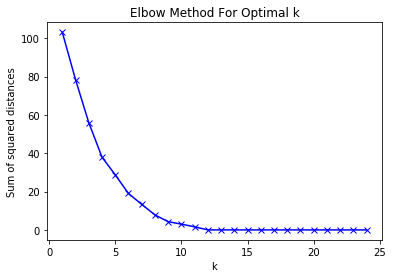

In [28]:
#analyze squared distances to find optimal kclusters  
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In the above plot the elbow is at k=9 indicating the optimal k for this dataset is 9

In [29]:
#rerun KMeans with 9 clusters
kclusters = 9
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering)

In [30]:
# add clustering labels

rest_cluster= toronto_rest
try:
  rest_cluster.drop(labels="Cluster Labels",axis = 1, inplace=True)
  rest_cluster.insert(0, 'Cluster Labels', kmeans.labels_)
except: 
  rest_cluster.insert(0, 'Cluster Labels', kmeans.labels_)
rest_cluster.head()


,Cluster Labels,Venue,Venue Latitude,Venue Longitude,Venue Category,Generic Type
0,2,Saigonlotus,43.681281,-79.382401,Japanese Restaurant,Asian Restaurant
1,2,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant,Asian Restaurant
2,7,Kanpai Snack Bar,43.664331,-79.368065,Taiwanese Restaurant,Asian Restaurant
3,3,Thai Room - Cabbagetown,43.664159,-79.368189,Thai Restaurant,Asian Restaurant
4,0,Tender Trap Restaurant,43.667724,-79.369485,Chinese Restaurant,Asian Restaurant


In [31]:
rest_cluster.sort_values(by=["Cluster Labels"], inplace=True)
rest_cluster.head(10) 

,Cluster Labels,Venue,Venue Latitude,Venue Longitude,Venue Category,Generic Type
41,0,Good View Chinese Restaurant,43.656791,-79.376139,Chinese Restaurant,Asian Restaurant
64,0,Yueh Tung Chinese Restaurant,43.655281,-79.385337,Chinese Restaurant,Asian Restaurant
57,0,China Wok,43.648124,-79.379121,Chinese Restaurant,Asian Restaurant
67,0,Duck,43.660739,-79.383913,Chinese Restaurant,Asian Restaurant
68,0,Manchu Wok,43.659524,-79.390538,Chinese Restaurant,Asian Restaurant
70,0,China King,43.660669,-79.383905,Chinese Restaurant,Asian Restaurant
71,0,Kowloon Seafood Dim Sum Restaurant,43.656217,-79.392418,Chinese Restaurant,Asian Restaurant
84,0,Modern Wok,43.647339,-79.384351,Chinese Restaurant,Asian Restaurant
88,0,Pearl Harbourfront,43.638157,-79.380688,Chinese Restaurant,Asian Restaurant
15,0,Crown Princess Fine Dining 伯爵名宴,43.666455,-79.387698,Chinese Restaurant,Asian Restaurant


In [32]:
import string
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#ys = [i + x + (i*x)**2 for i in range(len(highlight_clusters))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
highlight_cluster = 1
cluster_colors=["Grey","Red"]
# add markers to the map
markers_colors = []
rest_clusters=rest_cluster[rest_cluster["Cluster Labels"].isin(range(kclusters+1))]
#for lat, lon, poi,gen_type, cluster in zip(rest_cluster['Venue Latitude'], rest_cluster['Venue Longitude'],rest_cluster['Venue Category'],rest_cluster['Generic Type'], rest_cluster['Cluster Labels']):
#    label = folium.Popup(str(poi) + '('+gen_type+') Cluster ' + str(cluster), parse_html=True)
for lat, lon, name, poi, cluster in zip(rest_clusters['Venue Latitude'], rest_clusters['Venue Longitude'],rest_clusters['Venue'],rest_clusters['Venue Category'], rest_clusters['Cluster Labels']):
    p_label = str(name + "-"+ str(poi) +', Cluster ' + str(cluster))
    ch_include = set(string.ascii_uppercase+string.ascii_lowercase+string.digits+' '+string.punctuation)
    p_label = ''.join(ch for ch in p_label if ch in ch_include)
#    .replace("'","")
    label = folium.Popup(p_label, parse_html=True)
#    label.replace("'","",regex=False,inplace=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
#       color =  rainbow[highlight_clusters.index(cluster)] if cluster in highlight_clusters else "Grey",
        color=rainbow[cluster-1],
#        color = cluster_colors[int(cluster==highlight_cluster)],
        fill=True,
#       fill_color=cluster_colors[int(cluster==highlight_cluster)],
#        fill_color =  rainbow[highlight_clusters.index(cluster)] if cluster in highlight_clusters else "Grey",
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters